<h1 style = "font-size:3rem;color:darkcyan"> Music genre classication - Train CNN Model </h1>

In [1]:
# import libraries
import numpy as np
import tensorflow as tf
import json
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt

In [36]:
# importing dataset (.json)
def import_dataset_for_CNN(dataset_path):
    
    # open json file
    with open(dataset_path, 'r') as f:
        data = json.load(f)
    
    # split list into different np arrays
    mappings = np.array(data['mappings']) 
    inputs = np.array(data['MFCC'])
    targets = np.array(data['labels'])
    filenames = np.array(data['filenames'])
    
    return mappings, inputs, targets, filenames

In [37]:
mappings, inputs, targets, filenames = import_dataset('data.json')

In [39]:
# Add channel dimension for CNN --> 4D matrix
inputs = inputs[..., np.newaxis]
inputs.shape

(9981, 130, 13, 1)

In [40]:
def train_val_test_split(x, y, test_size = 0.25, val_size = 0.2):
    if (0 < test_size < 1)  and (0 < val_size < 1):
        train_size = 1 - test_size - val_size
        if train_size > 0:

            # train test split
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size)

            #train validation split
            x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size)

            return x_train, x_val, x_test, y_train, y_val, y_test
        else: 
            print('train size is too small, adjust test and validation sizes')
            return
    else:
        print('test and validation size should be between 0 and 1!')
        return

In [41]:
# split data into train, validation and test sets
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(inputs, targets, test_size = 0.25, val_size = 0.2)

In [42]:
x_train.shape

(5988, 130, 13, 1)

In [69]:
def build_CNN_model(input_shape, output_len):
    # create model
    model = tf.keras.Sequential()
    
    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape))
    model.add(tf.keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape))
    model.add(tf.keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2,2), activation = 'relu', input_shape = input_shape))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides = (2,2), padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    # flatten the output layer and feed into dense later
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    
    # output layer with softmax
    model.add(tf.keras.layers.Dense(output_len, activation = 'softmax'))
    
    return model

In [73]:
# build model
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
model = build_CNN_model(input_shape, len(mappings))

In [74]:
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer = optimizer,
             loss='sparse_categorical_crossentropy',
             metrics = ['accuracy'])


In [75]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 6, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 64, 6, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 31, 2, 32)        0         
 g2D)                                                            
                                                      

In [76]:
history = model.fit(x_train, y_train,
                   validation_data = (x_val, y_val),
                   batch_size = 32, 
                   epochs = 30)

Epoch 1/30
188/188 [==============================] - 4s 16ms/step - loss: 2.6100 - accuracy: 0.2131 - val_loss: 2.0072 - val_accuracy: 0.3093
Epoch 2/30
188/188 [==============================] - 3s 15ms/step - loss: 1.9080 - accuracy: 0.3560 - val_loss: 1.6024 - val_accuracy: 0.4282
Epoch 3/30
188/188 [==============================] - 3s 15ms/step - loss: 1.6479 - accuracy: 0.4247 - val_loss: 1.4368 - val_accuracy: 0.4756
Epoch 4/30
188/188 [==============================] - 3s 15ms/step - loss: 1.5024 - accuracy: 0.4651 - val_loss: 1.3429 - val_accuracy: 0.5177
Epoch 5/30
188/188 [==============================] - 3s 14ms/step - loss: 1.4082 - accuracy: 0.4995 - val_loss: 1.2822 - val_accuracy: 0.5391
Epoch 6/30
188/188 [==============================] - 3s 15ms/step - loss: 1.3376 - accuracy: 0.5264 - val_loss: 1.2199 - val_accuracy: 0.5785
Epoch 7/30
188/188 [==============================] - 3s 15ms/step - loss: 1.2744 - accuracy: 0.5421 - val_loss: 1.1994 - val_accuracy: 0.5731

In [77]:
def plot_training_history(history, figsize = [15,6]):
    
    fig, ax = plt.subplots(2, figsize=figsize)
    
    # create accuracy subplot
    ax[0].plot(history.history['accuracy'], label = 'Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'Testing Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].set_title('Accuracy Evaluation')
    
    # create error subplot
    ax[1].plot(history.history['loss'], label = 'Training Error')
    ax[1].plot(history.history['val_loss'], label = 'Testing Error')
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Error Evaluation')
    
    plt.show()

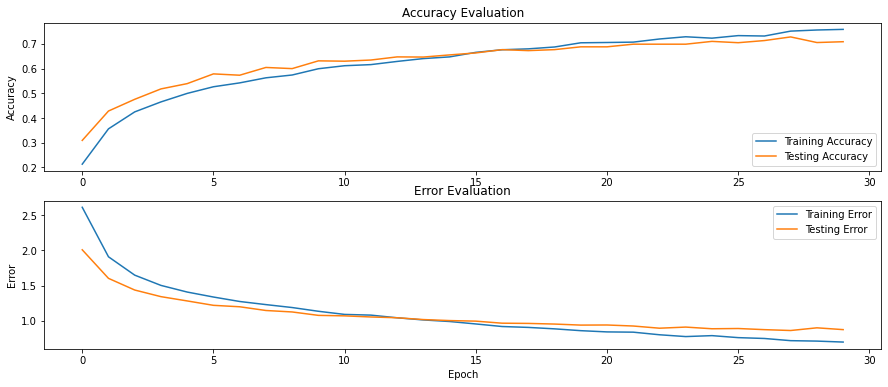

In [78]:
plot_training_history(history)

In [81]:
# test model using test data
test_error, test_accuracy = model.evaluate(x_test, y_test, verbose = True)

78/78 [==============================] - 0s 5ms/step - loss: 0.8445 - accuracy: 0.7135


In [82]:
# prediction
y_pred = model.predict(x_test)
pred_classes = np.argmax(y_pred, axis=1)

78/78 [==============================] - 0s 4ms/step


In [83]:
# visualize confusion matrix

def plot_confusion_matrix(true_target, predicted_target, classes, normalize = None, cmap= 'PuBu', size = [6,6], fontsize=9):
    # get confusion matrix
    labels = np.arange(0,len(classes), 1)
    cm = sklearn.metrics.confusion_matrix(true_target, predicted_target, labels = labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Absolute Confusion Matrix'
        
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap= cmap)
    ax.figure.colorbar(im, ax=ax)
    
    
    # set labels ticks
    ticks = np.arange(cm.shape[1])
    ax.set(xticks=ticks,
           yticks=ticks,
           xticklabels=classes, 
           yticklabels=classes,
          )
    
    ax.set_title(title, fontsize = 20)
    ax.set_ylabel('True Class', fontsize = fontsize)
    ax.set_xlabel('Predicted Class', fontsize = fontsize)
     
    # style tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", color = 'darkgrey', fontsize = fontsize)
    plt.setp(ax.get_yticklabels(), ha="right",
             rotation_mode="anchor", color = 'darkgrey', fontsize = fontsize)
    
    # plot text annotation inside each segment
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize = fontsize)

    fig.tight_layout()
    plt.show()

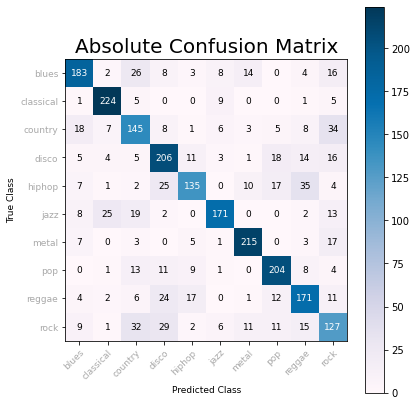

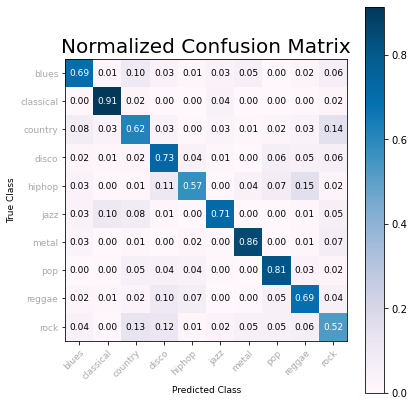

In [84]:
plot_confusion_matrix(y_test, pred_classes, classes = mappings, size = [6,6], normalize = False)
plot_confusion_matrix(y_test, pred_classes, classes = mappings, size = [6,6], normalize = True)